In [67]:
# 导入包
import os
import cv2 
import math
import random
import numpy as np
import pandas as pd
import mediapipe as mp
import tensorflow as tf
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ConfusionMatrixDisplay
import torch.nn.functional as F
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import time
# from dl2 import torch as dl2

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# from tensorflow.keras.applications import ResNet50  # check the difference later

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Dense, Flatten

In [68]:
actions = np.array(['Afraid', 'Happy','Angry','Annoyed','Bored','Excited'])

In [69]:
indices_to_keep = [0, 11, 12,                                                                                                                                                                                                                                                       13, 14, 15, 16, 23, 24, 25, 26, 27, 28]

In [70]:
label_map = {label:num for num, label in enumerate(actions)}

In [71]:
label_map

{'Afraid': 0, 'Happy': 1, 'Angry': 2, 'Annoyed': 3, 'Bored': 4, 'Excited': 5}

In [72]:
# 提取距离速度加速度方法
def calc_baseline(action_list):
    left_shoulder_right_shoulder_distance_list = []
    left_shoulder_left_elbow_distance_list = []
    left_elbow_left_wrist_distance_list = []
    left_hip_left_knee_distance_list = []
    std_list = []
    
    for i in range(len(action_list)):
        left_shoulder_right_shoulder_distance = math.hypot(action_list[i][11].x-action_list[i][12].x, action_list[i][11].y-action_list[i][12].y)
        left_shoulder_left_elbow_distance = math.hypot(action_list[i][11].x-action_list[i][13].x, action_list[i][11].y-action_list[i][13].y)
        left_elbow_left_wrist_distance = math.hypot(action_list[i][13].x-action_list[i][15].x, action_list[i][13].y-action_list[i][15].y)
        left_hip_left_knee_distance = math.hypot(action_list[i][23].x-action_list[i][25].x, action_list[i][23].y-action_list[i][25].y)
        left_shoulder_right_shoulder_distance_list.append(left_shoulder_right_shoulder_distance)
        left_shoulder_left_elbow_distance_list.append(left_shoulder_left_elbow_distance)
        left_elbow_left_wrist_distance_list.append(left_elbow_left_wrist_distance)
        left_hip_left_knee_distance_list.append(left_hip_left_knee_distance)
        # extract the distances, and append them into the lists respectively.
        
    #Calculate the std of these 4 lists, the goal of this part is selecting the most consistent distance.(minimum std)
    std0 = np.array(left_shoulder_right_shoulder_distance_list).std() 
    std1 = np.array(left_shoulder_left_elbow_distance_list).std()
    std2 = np.array(left_elbow_left_wrist_distance_list).std()
    std3 = np.array(left_hip_left_knee_distance_list).std()
    std_list = [std0, std1, std2, std3]
    std_min = min(std_list)
    std_index = std_list.index(std_min)
    if std_index == 0:
        norm_list = left_shoulder_right_shoulder_distance_list
    elif std_index == 1:
        norm_list = left_shoulder_left_elbow_distance_list
    elif std_index == 2:
        norm_list = left_elbow_left_wrist_distance_list
    elif std_index == 3:
        norm_list = left_hip_left_knee_distance_list
    return norm_list, std_index


def calc_all(action_list):
    norm_list, std_num = calc_baseline(action_list)

    left_ankle_left_hip_distance_list = []
    right_ankle_right_hip_distance_list = []
    left_wrist_left_shoulder_distance_list = []
    right_wrist_right_shoulder_distance_list = []
    left_wrist_nose_distance_list = []
    right_wrist_nose_distance_list = []
    left_wrist_left_hip_distance_list = []
    right_wrist_right_hip_distance_list = []
    
    for i in range(len(action_list)):
        left_ankle_left_hip_distance        = math.hypot(action_list[i][27].x-action_list[i][23].x, action_list[i][27].y-action_list[i][23].y)
        right_ankle_right_hip_distance      = math.hypot(action_list[i][28].x-action_list[i][24].x, action_list[i][28].y-action_list[i][24].y)
        left_wrist_left_shoulder_distance   = math.hypot(action_list[i][15].x-action_list[i][11].x, action_list[i][15].y-action_list[i][11].y)
        right_wrist_right_shoulder_distance = math.hypot(action_list[i][16].x-action_list[i][12].x, action_list[i][16].y-action_list[i][12].y)
        left_wrist_nose_distance            = math.hypot(action_list[i][15].x-action_list[i][0].x, action_list[i][15].y-action_list[i][0].y)
        right_wrist_nose_distance           = math.hypot(action_list[i][16].x-action_list[i][0].x, action_list[i][16].y-action_list[i][0].y)
        left_wrist_left_hip_distance        = math.hypot(action_list[i][15].x-action_list[i][23].x, action_list[i][15].y-action_list[i][23].y)
        right_wrist_right_hip_distance      = math.hypot(action_list[i][16].x-action_list[i][24].x, action_list[i][16].y-action_list[i][24].y)

        left_ankle_left_hip_distance_list.append(left_ankle_left_hip_distance)
        right_ankle_right_hip_distance_list.append(right_ankle_right_hip_distance)
        left_wrist_left_shoulder_distance_list.append(left_wrist_left_shoulder_distance)
        right_wrist_right_shoulder_distance_list.append(right_wrist_right_shoulder_distance)
        left_wrist_nose_distance_list.append(left_wrist_nose_distance)
        right_wrist_nose_distance_list.append(right_wrist_nose_distance)
        left_wrist_left_hip_distance_list.append(left_wrist_left_hip_distance)
        right_wrist_right_hip_distance_list.append(right_wrist_right_hip_distance)
        
    # 计算速度
    left_ankle_velocity_list = []
    right_ankle_velocity_list = []
    left_hip_velocity_list = []
    right_hip_velocity_list = []
    left_wrist_velocity_list = []
    right_wrist_velocity_list = []

    for i in range(len(action_list)-1):
        left_ankle_velocity     = math.hypot(action_list[i+1][27].x-action_list[i][27].x, action_list[i+1][27].y-action_list[i][27].y)/cut_frame
        right_ankle_velocity    = math.hypot(action_list[i+1][28].x-action_list[i][28].x, action_list[i+1][28].y-action_list[i][28].y)/cut_frame
        left_hip_velocity       = math.hypot(action_list[i+1][23].x-action_list[i][23].x, action_list[i+1][23].y-action_list[i][23].y)/cut_frame
        right_hip_velocity      = math.hypot(action_list[i+1][24].x-action_list[i][24].x, action_list[i+1][24].y-action_list[i][24].y)/cut_frame
        left_wrist_velocity     = math.hypot(action_list[i+1][15].x-action_list[i][15].x, action_list[i+1][15].y-action_list[i][15].y)/cut_frame
        right_wrist_velocity    = math.hypot(action_list[i+1][16].x-action_list[i][16].x, action_list[i+1][16].y-action_list[i][16].y)/cut_frame

        left_ankle_velocity_list.append(left_ankle_velocity)
        right_ankle_velocity_list.append(right_ankle_velocity)
        left_hip_velocity_list.append(left_hip_velocity)
        right_hip_velocity_list.append(right_hip_velocity)
        left_wrist_velocity_list.append(left_wrist_velocity)
        right_wrist_velocity_list.append(right_wrist_velocity)
        
    # 计算加速度
    left_ankle_acceleration_list = []
    right_ankle_acceleration_list = []
    left_hip_acceleration_list = []
    right_hip_acceleration_list = []
    left_wrist_acceleration_list = []
    right_wrist_acceleration_list = []

    for i in range(len(action_list)-2):
        left_ankle_acceleration = (left_ankle_velocity_list[i+1]-left_ankle_velocity_list[i])/cut_frame
        right_ankle_acceleration= (right_ankle_velocity_list[i+1]-right_ankle_velocity_list[i])/cut_frame
        left_hip_acceleration   = (left_hip_velocity_list[i+1]-left_hip_velocity_list[i])/cut_frame 
        right_hip_acceleration  = (right_hip_velocity_list[i+1]-right_hip_velocity_list[i])/cut_frame 
        left_wrist_acceleration = (left_wrist_velocity_list[i+1]-left_wrist_velocity_list[i])/cut_frame  
        right_wrist_acceleration= (right_wrist_velocity_list[i+1]-right_wrist_velocity_list[i])/cut_frame

        left_ankle_acceleration_list.append(left_ankle_acceleration)
        right_ankle_acceleration_list.append(right_ankle_acceleration)
        left_hip_acceleration_list.append(left_hip_acceleration)
        right_hip_acceleration_list.append(right_hip_acceleration)
        left_wrist_acceleration_list.append(left_wrist_acceleration)
        right_wrist_acceleration_list.append(right_wrist_acceleration)
    
    # 计算DataFrame
    LMA_measurement = { 
        
                    'norm_d': pd.Series(data = norm_list),
    
                    #Body
                   'l_ankle_l_hip_d': pd.Series(data = left_ankle_left_hip_distance_list),
                   'r_ankle_r_hip_d': pd.Series(data = right_ankle_right_hip_distance_list),
                   'l_wrist_nose_d': pd.Series(data = left_wrist_nose_distance_list),
                   'r_wrist_nose_d': pd.Series(data = right_wrist_nose_distance_list),
                   'l_wrist_l_hip_d': pd.Series(data = left_wrist_left_hip_distance_list),
                   'r_wrist_r_hip_d': pd.Series(data = right_wrist_right_hip_distance_list),
                    #Effort velocity
                   'l_ankle_v': pd.Series(data = left_ankle_velocity_list),
                   'r_ankle_v': pd.Series(data = right_ankle_velocity_list),
                   'l_hip_v': pd.Series(data = left_hip_velocity_list),
                   'r_hip_v': pd.Series(data = right_hip_velocity_list),
                   'l_wrist_v': pd.Series(data = left_wrist_velocity_list),
                   'r_wrist_v': pd.Series(data = right_wrist_velocity_list),
                    #Effort acceleration
                   'l_ankle_a': pd.Series(data = left_ankle_acceleration_list),
                   'r_ankle_a': pd.Series(data = right_ankle_acceleration_list),
                   'l_hip_a': pd.Series(data = left_hip_acceleration_list),
                   'r_hip_a': pd.Series(data = right_hip_acceleration_list),
                   'l_wrist_a': pd.Series(data = left_wrist_acceleration_list),
                   'r_wrist_a': pd.Series(data = right_wrist_acceleration_list),   
                  }
    # 处理DataFrame
    LMA_measurement_df = pd.DataFrame(LMA_measurement)

    # 根据std位置不同，选择不同norm数据
    if std_num == 0:
        norm = LMA_measurement_df['norm_d']/40
    elif std_num == 1:
        norm = LMA_measurement_df['norm_d']/30
    elif std_num == 2:
        norm = LMA_measurement_df['norm_d']/25
    elif std_num == 3:
        norm = LMA_measurement_df['norm_d']/60
    Seven_LMA_measurement_norm_df = LMA_measurement_df.iloc[:, :7].div(norm, axis=0) 
    LMA_measurement_norm_df = pd.concat([Seven_LMA_measurement_norm_df, LMA_measurement_df.iloc[:, 7:]], axis=1)
    LMA_measurement_norm_df = LMA_measurement_norm_df.dropna()
    LMA_measurement_norm_df = LMA_measurement_norm_df.drop(columns = ['norm_d']) 
    return LMA_measurement_norm_df

# 归一化处理函数
def calc_norm(action_df):
    normalized = np.arctan(MinMaxScaler().fit_transform(action_df.T).T)
    norm_action_df = pd.DataFrame(normalized, columns=action_df.columns)
    return norm_action_df

In [73]:
cut_frame = 10

static_xy_list = []
lma_list = []
array_history = []
label_list = []

# current_dir = os.getcwd()
# print(current_dir)
# train_path =  os.path.join(current_dir,'train')
# print(train_path)
train_path =  os.path.join(r'/Users/biaowang/Desktop/projectHong/six_types/train')

for sub_folder in actions:
    print(sub_folder)
    sub_folder_path = os.path.join(train_path,sub_folder)
    for category_folder in os.listdir(sub_folder_path):
        if category_folder.startswith('.'):
            continue
        current_frame = 0
        category_folder_path = os.path.join(sub_folder_path, category_folder)
        for file in os.listdir(category_folder_path):
            if file.startswith('.'):
                continue
            file_path = os.path.join(category_folder_path, file)
            # file_path = train_path + '/'+ sub_folder + '/' + category_folder + '/' + file
            # print(file_path)
            res = np.load(file_path, allow_pickle=True)
            keypoints_xy_list = []
            # 只提取精简之后关键点
            for k in indices_to_keep:
                keypoint_xy = np.array([res[k].x, res[k].y])
                keypoints_xy_list.append(keypoint_xy)
            static_xy_list.append(np.array(keypoints_xy_list).flatten())
            
            if current_frame % 10 == 0:
                lma_list.append(res)
                
            current_frame = current_frame + 1
            
            if len(lma_list) == 3:
                lma_df = calc_all(lma_list)
                norm_lma_df = calc_norm(lma_df)
                norm_lma_np = norm_lma_df.values
                norm_lma_1np = norm_lma_np.reshape(-1)
                np_static_xy_list = np.array(static_xy_list)
                tem_merge = np.concatenate((np_static_xy_list, np.tile(norm_lma_1np, (np_static_xy_list.shape[0], 1))), axis=1)
                array_history.append(tem_merge)
                
                for i in range(len(np_static_xy_list)):
                    label_list.append(label_map[sub_folder])
                    
                static_xy_list = []
                lma_list = []

# 最终融合后的二维np数组
merge_train = np.vstack(array_history) 

Afraid
Happy
Angry
Annoyed
Bored
Excited


In [74]:
merge_train.shape

(77476, 44)

/var/folders/fl/vvv7fdkj2139zp4my83vm89r0000gn/T/ipykernel_10353/2641105157.py:14: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7,


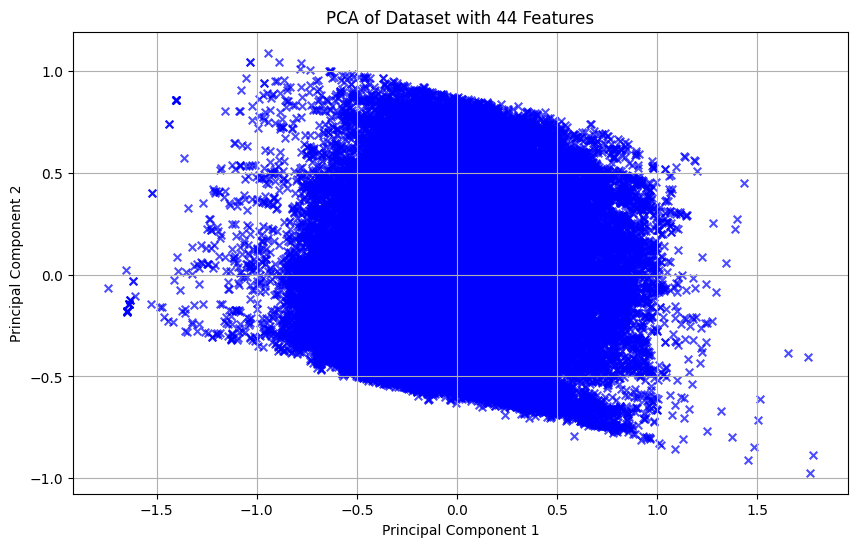

/var/folders/fl/vvv7fdkj2139zp4my83vm89r0000gn/T/ipykernel_10353/2641105157.py:37: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(pca_df_3d['PC1'], pca_df_3d['PC2'], pca_df_3d['PC3'],


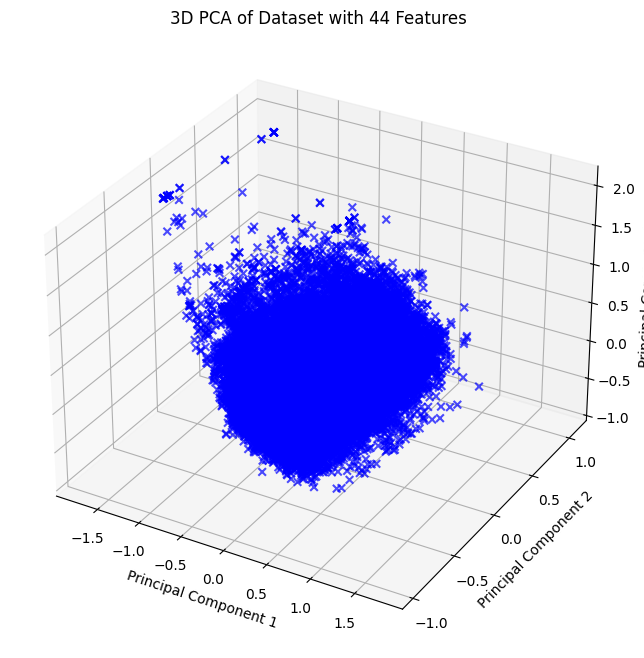

In [75]:
# Data visulization
df = pd.DataFrame(merge_train, columns=[f'Feature_{i}' for i in range(1, 45)])

# Fit PCA 2d
pca = PCA(n_components=2)  # Reduce to 2 dimensions
pca_result = pca.fit_transform(df)

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Scatter plot of PCA results
plt.figure(figsize=(10, 6))
# plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, 
            s=30,  # Set the size to a smaller value
            marker='x',  # Use 'x' to represent markers as crosses
            color='blue',  # Color of the crosses
            edgecolor='black')  
plt.title('PCA of Dataset with 44 Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Fit PCA 3d
pca_3d = PCA(n_components=3)  # Reduce to 3 dimensions
pca_result_3d = pca_3d.fit_transform(df)

# Create a DataFrame for easier plotting
pca_df_3d = pd.DataFrame(data=pca_result_3d, columns=['PC1', 'PC2', 'PC3'])

# Scatter plot of PCA results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use smaller crosses as markers
ax.scatter(pca_df_3d['PC1'], pca_df_3d['PC2'], pca_df_3d['PC3'], 
           alpha=0.7, s=30, marker='x', color='blue', edgecolor='black')

# Step 4: Set the title and labels
ax.set_title('3D PCA of Dataset with 44 Features')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Show the plot
plt.show()


# # Apply t-SNE
# tsne = TSNE(n_components=2, random_state=42)
# tsne_result = tsne.fit_transform(df)

# # Create a DataFrame for t-SNE results
# tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])

# # Scatter plot of t-SNE results
# plt.figure(figsize=(10, 6))
# plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], alpha=0.7, 
#             s=30,  # Set the size to a smaller value
#             marker='x',  # Use 'x' to represent markers as crosses
#             color='blue',  # Color of the crosses
#             edgecolor='black')  
# plt.title('t-SNE of Dataset with 44 Features')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.grid(True)
# plt.show()

In [76]:
len(label_list)

77476

In [77]:
counter = Counter(label_list)
Afraid_num =  counter[0]
Happy_num = counter[1]
print(Afraid_num, Happy_num)

14490 13746


In [78]:
# 整理训练集
X_train = merge_train
y_train = to_categorical(label_list).astype(int)
# print(X_train.shaple)

In [79]:
cut_frame = 10

static_xy_list = []
lma_list = []
array_history = []
test_label_list = []

# test_path =  os.path.join(r'C:\Users\zcy\Desktop\BC_Dance_Clip_Change\test')
test_path =  os.path.join(r'/Users/biaowang/Desktop/projectHong/six_types/test')

for sub_folder in actions:
    print(sub_folder)
    sub_folder_path = os.path.join(test_path,sub_folder)
    for category_folder in os.listdir(sub_folder_path):
        if category_folder.startswith('.'):
            continue
        print(category_folder)
        current_frame = 0
        category_folder_path = os.path.join(sub_folder_path, category_folder)
        for file in os.listdir(category_folder_path):
            if file.startswith('.'):
                continue
            file_path = os.path.join(category_folder_path, file)
#             print(file_path)
            res = np.load(file_path, allow_pickle=True)
            keypoints_xy_list = []
            for k in indices_to_keep:
                keypoint_xy = np.array([res[k].x, res[k].y])
                keypoints_xy_list.append(keypoint_xy)
            static_xy_list.append(np.array(keypoints_xy_list).flatten())
            
            if current_frame % 10 == 0:
                lma_list.append(res)
                
            current_frame = current_frame + 1
            
            if len(lma_list) == 3:
                lma_df = calc_all(lma_list)
                norm_lma_df = calc_norm(lma_df)
                norm_lma_np = norm_lma_df.values
                norm_lma_1np = norm_lma_np.reshape(-1)
                np_static_xy_list = np.array(static_xy_list)
                tem_merge = np.concatenate((np_static_xy_list, np.tile(norm_lma_1np, (np_static_xy_list.shape[0], 1))), axis=1)
                array_history.append(tem_merge)
                
                for i in range(len(np_static_xy_list)):
                    test_label_list.append(label_map[sub_folder])
                    
                static_xy_list = []
                lma_list = []

# 最终融合后的二维np数组
test_merge_train = np.vstack(array_history)   

Afraid
Afraid_09
Happy
Happy_09
Angry
Angry_10
Annoyed
Annoyed_08
Bored
Bored_08
Excited
Exicted_09


In [80]:
test_merge_train.shape

(18873, 44)

In [81]:
len(test_label_list)

18873

In [82]:
counter = Counter(test_label_list)
Afraid_num =  counter[0]
Happy_num = counter[1]
print(Afraid_num, Happy_num)

3261 3175


In [83]:
# 整理测试集
X_test = test_merge_train
y_test = to_categorical(test_label_list).astype(int)

In [84]:
train_indices = np.random.permutation(X_train.shape[0])
test_indices =  np.random.permutation(X_test.shape[0])

In [85]:
X_train = X_train[train_indices]
y_train = y_train[train_indices]

X_test = X_test[test_indices]
y_test = y_test[test_indices]

# print(X_train[0])
# print(X_train[1])

In [86]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape
# print(X_train[0])
# print()
# print(y_train[0])

((77476, 44), (77476, 6), (18873, 44), (18873, 6))

In [87]:
np.random.seed(0)
tf.random.set_seed(0)

In [88]:
# 搭模型进行训练
def train_and_test_model(X_train, y_train, X_test, y_test):
    
    # 搭建模型
    model = Sequential()  
    model.add(Dense(64, activation='relu', input_shape=(44, )))
#     model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
#     model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))

#     编译模型 调试参数
#     learning_rate = 0.001
#     batch_size = 32
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
#     编译模型 默认参数
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    # 训练
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Percentage')
    plt.xlabel('Epoch')
    plt.legend(['train','test'])
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train','test'])
    plt.show()
    # 查看模型结构
    model.summary()
    return model

In [89]:
# model = train_and_test_model(X_train, y_train, X_test, y_test)

In [90]:
# 1D convelution block:
class Conv1DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # If the input channels ！= output channels, we apply a 1*1 convolution。
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride), 
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

In [91]:
# Define a resnet with the previous convelution block.
class ResNet1D(nn.Module):
    def __init__(self, input_dim, num_classes,dropout_rate=0.5):
        super().__init__()
        self.initial_layer = nn.Conv1d(1, 64, kernel_size=3, padding=1)  # Input channels = 1 for tabular  arguments: in_channels,out_channels...
        self.bn = nn.BatchNorm1d(64)
        
        # Define the residual blocks
        self.layer1 = Conv1DBlock(64, 64)
        self.layer2 = Conv1DBlock(64, 64)
        # self.layer3 = Conv1DBlock(64, 64)
        # self.layer4 = Conv1DBlock(64, 64)

        # Adding pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  # Pooling layer

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer with specified dropout rate (Only activated in training mode, not in evaluation mode)
        
        # Flatten and classify
        self.flatten = nn.Flatten()  # From 1000*64*input_dim ==>  1000*(64*input_dim)
        self.fc = nn.Linear(64 * input_dim//2, num_classes) # A fully connected layer to logics  (We add //2 since the pooling layer reduce the size of the output)

        

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension for 1D convolution   sample_number * 1 * 44
        x = F.relu(self.bn(self.initial_layer(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)

        # Apply pooling
        x = self.pool(x)  # Apply pooling after the residual layers

        x = self.flatten(x)
        x = self.fc(x) # This is the last layer, the fc was defined before.
        return x

        # Do we need a softmax for output  --No

In [92]:
# An function to evaluate accuracy:
# y_hat is the raw logics directly from model, (not probability, it didn't go throught softmax layer)
# y is one-hot
#Returns: accuracy (float): The accuracy calculated as a percentage (0 to 1).
def accuracy(y_hat, y):
    # Get the predicted class indices
    predicted = torch.argmax(y_hat, dim=1)  # Get index of the max logit along the class dimension
    # Compute the number of correct predictions
    correct = (predicted == torch.argmax(y, dim=1)).sum().item()  # Compare to true labels and sum correct
    
    # Calculate accuracy
    acc = correct / y.size(0)  # Total predictions
    return acc

In [93]:
# Dataloader:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class for tabular data
class TabularDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (np.ndarray or torch.Tensor): Feature data.
            y (np.ndarray or torch.Tensor): Target labels.
        """
        # Convert inputs to PyTorch tensors
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)  # Ensure labels are long integers for CrossEntropyLoss

    def __len__(self):
        # Return the total number of samples
        return len(self.X)

    def __getitem__(self, idx):
        # Retrieve the sample (features and label) at index `idx`
        return self.X[idx], self.y[idx]



# Create dataset and data loaders
train_dataset = TabularDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TabularDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# print(test_dataset)

# print(X_train.shape)
# print(y_train.shape)

# # Check the first batch
# for X_batch, y_batch in train_loader:
#     print("Batch feature shape:", X_batch.shape)  # Should be [batch_size, num_features]
#     print("Batch label shape:", y_batch.shape)  # Should be [batch_size] (if using integer labels)
#     print()
#     print(X_batch[0])
#     print(y_batch[0])
#     print()
    
#     break  # Remove this break to see all batches

# for x,y in test_loader:
#     print(x.shape)
#     print(y.shape)
#     print(x)
#     print(y)
#     print()
    

In [94]:
def evaluate_accuracy(model, data_loader, device):
    """
    Evaluate the accuracy of a model on the given data loader.

    Parameters:
    - model: The neural network model to evaluate.
    - data_loader: DataLoader object containing the test dataset.
    - device: The device to run the computations (CPU or GPU).

    Returns:
    - accuracy (float): The accuracy of the model on the test set.
    """
    model.eval()  # Set the model to evaluation mode (no dropout here)
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in data_loader:
            # print("what happen here (evaluation process):")
            # print(inputs)
            # print(labels)
            inputs, labels = inputs.to(device), labels.to(device)  # Move to appropriate device
            
            outputs = model(inputs)  # Get model predictions
            
            # Get predicted class indices
            _, predicted = torch.max(outputs.data, 1)  # Maximum logit prediction
            print("The laels.size(0)".format(labels.size(0)))
            total += labels.size(0)  # Number of samples in batch
            correct += (predicted == torch.argmax(labels, dim=1)).sum().item()  # Count correct predictions
    # print("There are {} samples in this epoch totally".format(total))
    # print("correct prediction number: {}".format(correct))
    # print()
    accuracy = correct / total  # Calculate accuracy as a fraction
    return accuracy


In [95]:
# Build a trainer:
def trainer(net, train_loader, test_loader, num_epochs, lr, device):
    def init_weights(m):
        if isinstance(m,nn.Linear) or isinstance(m,nn.Conv1d):
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss_func = nn.CrossEntropyLoss()
    # animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
    #                         legend=['train loss', 'train acc', 'test acc'])
    # timer, num_batches = d2l.Timer(), len(train_iter)

    epoch_count = 1

    # For plotting losses and accuracy
    train_losses, train_accuracies, test_accuracies = [], [], []
    for epoch in range(num_epochs):
        net.train() # Activate the dropout layers
        running_loss = 0.0
        correct = 0
        total = 0  # These are the number of samples and the number of correct predictions

        start_time = time.time()
        batch_count = 1
    
        for X, y in train_loader:  # X is 32*44 (batch_size*freature_num)  y is one-hot

            print('This is epoch: {}  batch:{}'.format(epoch_count,batch_count))
            batch_count += 1

            X, y = X.to(device), y.to(device)
            
            optimizer.zero_grad()
            y_hat = net(X)
            loss = loss_func(y_hat, torch.argmax(y, dim=1)) #Remark: y_hat is the raw logics from the net(without softmax) Y is one-hot, we convert it to class labels
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * X.size(0) # The total loss 
            correct += accuracy(y_hat, y) * X.size(0) # The total number of correct prediction in this batch(32 samples   set in dataloader)
            total += X.size(0) # The total number of samples

        # After every epoch, we calculate: 1. average loss 2. acurracy 
        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss) # append these losses,accuracy for plotting later
        train_accuracies.append(train_acc)

        test_acc = evaluate_accuracy(net, test_loader, device)
        test_accuracies.append(test_acc)

        end_time = time.time()

        print(epoch_count)
        epoch_count += 1

    # Plotting
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
    #       f'test acc {test_acc:.3f}')
    # print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
    #       f'on {str(device)}')


training on cpu
This is epoch: 1  batch:1
This is epoch: 1  batch:2
This is epoch: 1  batch:3
This is epoch: 1  batch:4
This is epoch: 1  batch:5
This is epoch: 1  batch:6
This is epoch: 1  batch:7
This is epoch: 1  batch:8
This is epoch: 1  batch:9
This is epoch: 1  batch:10
This is epoch: 1  batch:11
This is epoch: 1  batch:12
This is epoch: 1  batch:13
This is epoch: 1  batch:14
This is epoch: 1  batch:15
This is epoch: 1  batch:16
This is epoch: 1  batch:17
This is epoch: 1  batch:18
This is epoch: 1  batch:19
This is epoch: 1  batch:20
This is epoch: 1  batch:21
This is epoch: 1  batch:22
This is epoch: 1  batch:23
This is epoch: 1  batch:24
This is epoch: 1  batch:25
This is epoch: 1  batch:26
This is epoch: 1  batch:27
This is epoch: 1  batch:28
This is epoch: 1  batch:29
This is epoch: 1  batch:30
This is epoch: 1  batch:31
This is epoch: 1  batch:32
This is epoch: 1  batch:33
This is epoch: 1  batch:34
This is epoch: 1  batch:35
This is epoch: 1  batch:36
This is epoch: 1  bat

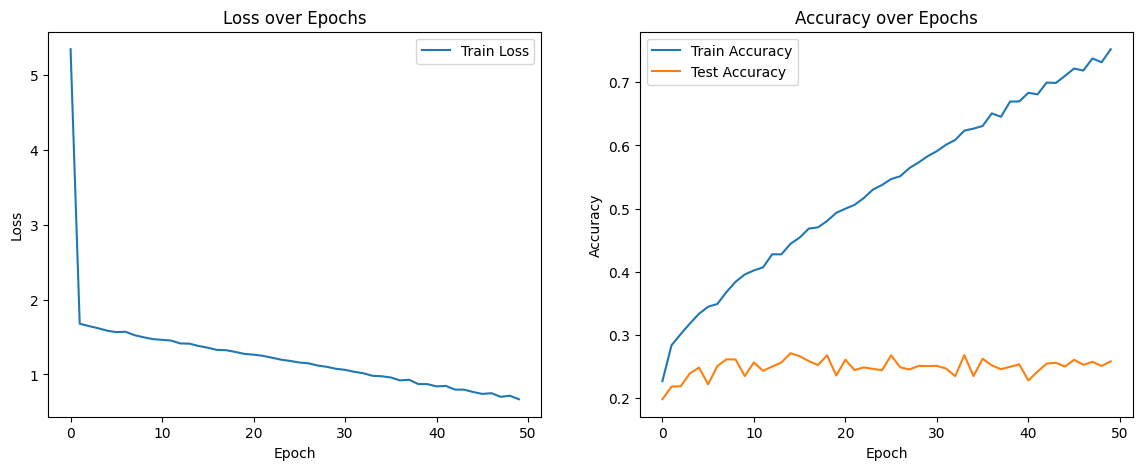

In [348]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 0.1
net = ResNet1D(input_dim=44, num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
trainer(net, train_loader, test_loader, 50, lr, device)

In [ ]:
y_true = np.argmax(y_test, axis=1).tolist()
y_pred_dnn = model.predict(X_test)
y_pred_dnn = np.argmax(y_pred_dnn, axis=1).tolist()
accuracy_score(y_true, y_pred_dnn)

In [ ]:
print('Deep Neural Network Classifier:\n')
ConfusionMatrixDisplay.from_predictions(y_true,y_pred_dnn)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
print(precision_score(y_true, y_pred_dnn,average='macro'))
print(recall_score(y_true, y_pred_dnn,average='macro'))
print(f1_score(y_true, y_pred_dnn,average='macro'))

In [ ]:
# 经典机器学习方法结果检查
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

In [ ]:
# 固定随机数种子
seed = 1

In [ ]:
# Random Forest Classifier
forest = RandomForestClassifier(random_state=seed)
forest.fit(X_train,y_train)
y_pred_forest = forest.predict(X_test)
y_true = np.argmax(y_test, axis=1).tolist()
y_pred_forest = np.argmax(y_pred_forest, axis=1).tolist()
accuracy_score(y_true, y_pred_forest)

In [ ]:
print('Random Forest Classifier:\n')
ConfusionMatrixDisplay.from_predictions(y_true,y_pred_forest)

In [ ]:
precision_score(y_true, y_pred_forest, average='macro')

In [ ]:
recall_score(y_true, y_pred_forest, average='macro')

In [ ]:
f1_score(y_true, y_pred_forest, average='macro')

In [ ]:
# logistics regression
linear = LogisticRegression(max_iter=2000, random_state=seed)
y_train_1d = np.argmax(y_train, axis=1)
linear.fit(X_train, y_train_1d)
y_pred_linear = linear.predict(X_test)
accuracy_score(y_true, y_pred_linear)

In [ ]:
print('Linear Classifier:\n')
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_linear)

In [ ]:
precision_score(y_true, y_pred_linear, average='macro')

In [ ]:
recall_score(y_true, y_pred_linear, average='macro')

In [ ]:
f1_score(y_true, y_pred_linear, average='macro')

In [ ]:
# decison tree
tree = DecisionTreeClassifier(random_state=seed)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_true = np.argmax(y_test, axis=1).tolist()
y_pred_tree = np.argmax(y_pred_tree, axis=1).tolist()
accuracy_score(y_true, y_pred_tree)

In [ ]:
print('Decision Tree Classifier:\n')
ConfusionMatrixDisplay.from_predictions(y_true,y_pred_tree)

In [ ]:
precision_score(y_true, y_pred_tree, average='macro')

In [ ]:
recall_score(y_true, y_pred_tree, average='macro')

In [ ]:
f1_score(y_true, y_pred_tree, average='macro')

In [ ]:
# SVM
svm = LinearSVC(max_iter=2500, random_state=seed)
y_train_1d = np.argmax(y_train, axis=1)
svm.fit(X_train, y_train_1d)
y_pred_svm = svm.predict(X_test)
accuracy_score(y_true, y_pred_svm)

In [ ]:
print('SVM Classifier:\n')
ConfusionMatrixDisplay.from_predictions(y_true,y_pred_svm)

In [ ]:
precision_score(y_true, y_pred_svm, average='macro')

In [ ]:
recall_score(y_true, y_pred_svm, average='macro')

In [ ]:
f1_score(y_true, y_pred_svm, average='macro')

In [ ]:
# Naive bayes
bayes = GaussianNB()
y_train_1d = np.argmax(y_train, axis=1)
bayes.fit(X_train, y_train_1d)
y_pred_bayes = bayes.predict(X_test)
accuracy_score(y_true, y_pred_bayes)

In [ ]:
print('Naive Bayes Classifier:\n')
ConfusionMatrixDisplay.from_predictions(y_true,y_pred_bayes)

In [ ]:
precision_score(y_true, y_pred_bayes, average='macro')

In [ ]:
recall_score(y_true, y_pred_bayes, average='macro')

In [ ]:
f1_score(y_true, y_pred_bayes, average='macro')